**TODO:**
- **Critical:** dive into inflation expectations in the first half of 20th century (golden standard?)
- Test on data of different countries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit 

np.set_printoptions(suppress=True)

%matplotlib widget

In [3]:
# source: https://data.bls.gov/pdq/SurveyOutputServlet
# monthly unemployment rate
raw_unemployment_data = pd.read_csv("USUnemployment.csv", index_col="Year")

mean_unemployment = (raw_unemployment_data.mean(axis="columns") / 100).round(4)
mean_unemployment.name = "mean_unemployment"
mean_unemployment.tail()

Year
2015    0.0528
2016    0.0488
2017    0.0434
2018    0.0389
2019    0.0367
Name: mean_unemployment, dtype: float64

In [4]:
# source: https://fred.stlouisfed.org/series/CPIAUCNS 
# monthly CPI
raw_inflation_data = pd.read_csv(
    "CPIAUCNS.csv", 
    parse_dates=["observation_date"], 
    date_format="%Y-%m-%d",
    index_col="observation_date"
)


inflation_rate = (
    raw_inflation_data["CPIAUCNS"]
    .groupby(raw_inflation_data.index.year)
    .apply(lambda x: x.iat[-1] / x.iat[0] - 1)
)

inflation_rate.name = "inflation_rate"
inflation_rate

observation_date
1913    0.020408
1914    0.010000
1915    0.019802
1916    0.115385
1917    0.170940
          ...   
2020    0.009703
2021    0.065830
2022    0.055661
2023    0.025323
2024    0.022943
Name: inflation_rate, Length: 112, dtype: float64

The reason why the Phillips-curve was stable up until 1970 are the stable inflation expectations. 
Considering that people are neither dump nor blind it is safe to assume that the inflation expectations from 1900 to 1970 were the mean of the inflation in the said time period

In [6]:
# https://fred.stlouisfed.org/series/MICH
# Median expected price change next 12 months, Surveys of Consumers.
raw_inflation_expectations = pd.read_csv(
    "michigan_inflation_expectations.csv",
    parse_dates=["observation_date"],
    date_format="%Y-%m-%d",
    index_col="observation_date"
)


mean_inflation_until_1970 = inflation_rate.loc[:1970].mean().round(5)
expected_inflation_until_1970 = pd.Series([mean_inflation_until_1970]*70, index=range(1900,1970))

expected_inflation_after_1977 = pd.Series()
for year, expectations in raw_inflation_expectations["MICH"].groupby(raw_inflation_expectations.index.year):
    expected_inflation_after_1977[year] = expectations.iat[0].round(4) / 100


expected_inflation = pd.concat([expected_inflation_until_1970, expected_inflation_after_1977])
expected_inflation = expected_inflation.reindex(range(1900,2025))
expected_inflation.name = "expected_inflation"
expected_inflation.tail()

2020    0.025
2021    0.030
2022    0.049
2023    0.039
2024    0.029
Name: expected_inflation, dtype: float64

In [7]:
LIMITING_QUANTILE = 1
dataset = pd.concat([inflation_rate, mean_unemployment, expected_inflation], axis="columns", join="inner")
quantile = dataset.quantile(LIMITING_QUANTILE)

dataset.loc[dataset["inflation_rate"]>quantile["inflation_rate"], "inflation_rate"] = np.nan
dataset.loc[dataset["mean_unemployment"]>quantile["mean_unemployment"], "mean_unemployment"] = np.nan
dataset.loc[dataset["expected_inflation"]>quantile["expected_inflation"], "expected_inflation"] = np.nan

dataset.head()

,inflation_rate,mean_unemployment,expected_inflation
1948,0.016878,0.0375,0.02593
1949,-0.016667,0.0605,0.02593
1950,0.063830,0.0521,0.02593
1951,0.043307,0.0328,0.02593
1952,0.007547,0.0302,0.02593


**Developing a model to describe the phenomenon**

In [9]:
def index_dataset(start, end):
    XY = dataset.loc[start:end,["mean_unemployment","expected_inflation"]].dropna()
    return {
        "X": XY["mean_unemployment"],
        "Y": XY["expected_inflation"],
        "XY": XY,
        "z": dataset["inflation_rate"].loc[XY.index].array
    }

In [10]:
# TODO: typing
def r_squared(func, X, y, *params):
    y_exp = func(X, *params)
    ss_res = sum((y - y_exp)**2)
    ss_total = sum((y-y.mean())**2)
    return round(1 - ss_res / ss_total, 4)

Linear regeression

In [12]:
XY, z = index_dataset(1970,None)["XY"], index_dataset(1970,None)["z"]

reg = LinearRegression().fit(XY,z)
print("Coefficients: " + str(np.array([*reg.coef_, reg.intercept_]).round(4)))
print("R^2 = " + str(r_squared(reg.predict, XY, z)))

Coefficients: [-0.117   1.2506 -0.006 ]
R^2 = 0.7045


Non linear curve (a*y)/(b*x) + c

In [14]:
def curve_func(X, a, b):
    x, y = X
    return a*(y/x) + b

XY, z = index_dataset(1970,None)["XY"], index_dataset(1970,None)["z"]

popt, pcov = curve_fit(curve_func, XY.T.to_numpy(), z, p0=[1,0])

print("Coefficients: " + str(popt))
print("R^2 = " + str(r_squared(curve_func, XY.T.to_numpy(), z, *popt)))

del XY, z

Coefficients: [ 0.08034412 -0.01640672]
R^2 = 0.6269


In [15]:
def inverted_curve_func(*X_inv):
    x, z = X_inv
    # a*(y/x) + b = z
    # y/x = (z-b)/a
    # y = (z-b)/a * x
    # after 1970: a = 0.08034412 b = -0.01640672
    return (z+0.01640672)/0.08034412 * x

X, z = index_dataset(None,1970)["X"], index_dataset(None,1970)["z"]

expected_expectations = inverted_curve_func(X,z)

In [16]:
r_squared(
    curve_func,
    (index_dataset(None,1970)["X"], expected_expectations),
    index_dataset(None,1970)["z"],
    0.08034412, -0.01640672
)

1.0

In [17]:
expected_expectations.head()

1948    0.015535
1949   -0.000196
1950    0.052030
1951    0.024378
1952    0.009004
Name: mean_unemployment, dtype: float64

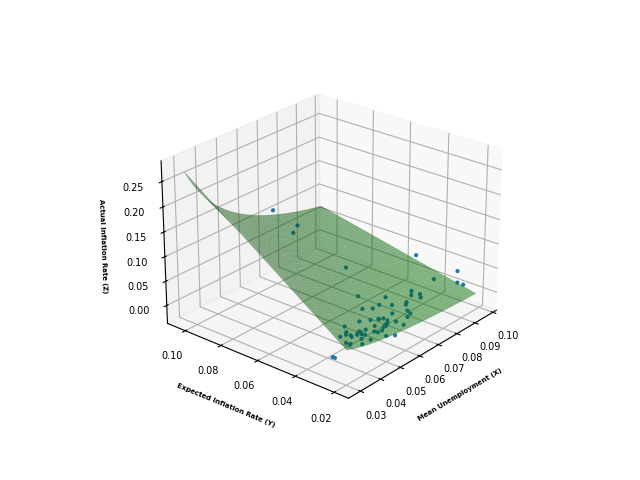

In [18]:
# plotting the data points and the fitted curve
fig = plt.figure(clear=True)
ax = fig.add_subplot(projection='3d')
fontdict = {
    "fontweight":"bold",
    "size":5,
    "fontvariant":"normal"
}

ax.view_init(25, -140, 0)
ax.scatter(xs=dataset["mean_unemployment"], ys=dataset["expected_inflation"], zs=dataset["inflation_rate"], s=4, alpha=1)

# Figure
fig.set_label("Fitted unemployment, expected inflation and the actual inflation")

# X-axis
ax.set_xlabel("Mean Unemployment (X)",fontdict=fontdict)
ax.tick_params(axis="x",labelsize=7)

# Y-axis
ax.set_ylabel("Expected Inflation Rate (Y)",fontdict=fontdict);
ax.tick_params(axis="y",labelsize=7)

# Z-axis
ax.set_zlabel("Actual Inflation Rate (Z)",fontdict=fontdict)
ax.tick_params(axis="z",labelsize=7)



x_range = np.linspace(dataset["mean_unemployment"].min(), dataset["mean_unemployment"].max()) 
y_range = np.linspace(dataset["expected_inflation"].min(), dataset["expected_inflation"].max()) 
x_plot, y_plot = np.meshgrid(x_range, y_range) 
z_plot = curve_func((x_plot, y_plot), *popt) 
ax.plot_surface(x_plot, y_plot, z_plot, color='green', alpha=0.5);